In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Библиотеки загружены")

print("Загрузка данных Boston Housing...")
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
                 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(data, columns=feature_names)
df['MEDV'] = target  # Median value of homes in $1000's

print(f"Данные загружены: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"🎯 Целевая переменная: MEDV (цена дома в тыс. $)")
print(f"📈 Признаки: {', '.join(feature_names)}")
print("\n👀 Первые 5 строк:")
print(df.head())

Библиотеки загружены
Загрузка данных Boston Housing...
Данные загружены: 506 строк, 14 столбцов
🎯 Целевая переменная: MEDV (цена дома в тыс. $)
📈 Признаки: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, B, LSTAT

👀 Первые 5 строк:
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


In [16]:

print("="*80)
print("2. ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ")
print("="*80)

print("\n2.1 Проверка пропущенных значений:")
missing_values = df.isnull().sum()
print(missing_values)

if missing_values.sum() == 0:
    print("Пропущенных значений нет")
else:
    print(f"⚠ Найдено {missing_values.sum()} пропущенных значений")

    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype in ['int64', 'float64']:
                median_val = df[col].median()
                df[col] = df[col].fillna(median_val)
                print(f"  {col}: заполнено медианой ({median_val})")
            else:
                mode_val = df[col].mode()[0]
                df[col] = df[col].fillna(mode_val)
                print(f"  {col}: заполнено модой ('{mode_val}')")

print("\n2.2 Типы данных:")
print(df.dtypes)

print("\n Предобработка завершена")

2. ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ

2.1 Проверка пропущенных значений:
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64
Пропущенных значений нет

2.2 Типы данных:
CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

 Предобработка завершена


In [17]:

print("="*80)
print("3. ОПИСАТЕЛЬНАЯ СТАТИСТИКА")
print("="*80)

print("\n3.1 Основные статистики для всех признаков:")
print(df.describe().round(2))

print("\n3.2 Статистика для дискретных признаков:")

print("\nCHAS (близость к реке Charles):")
print(df['CHAS'].value_counts())
print(f"0: не граничит с рекой - {df['CHAS'].value_counts()[0]} домов ({(df['CHAS'].value_counts()[0]/len(df)*100):.1f}%)")
print(f"1: граничит с рекой - {df['CHAS'].value_counts()[1]} домов ({(df['CHAS'].value_counts()[1]/len(df)*100):.1f}%)")

print("\n3.3 Комментарии к статистике:")
print("""
• CRIM (уровень преступности):
  - Сильно скошенное распределение (среднее 3.61, но 75% значений ≤ 3.68)
  - Максимальное значение 88.98 - явный выброс

• ZN (доля земли под жилую застройку):
  - Большинство значений = 0 (75-й перцентиль = 0)
  - Максимальное значение 100

• RM (среднее число комнат):
  - Распределение близко к нормальному (6.28 ± 0.70)
  - Коррелирует с ценой

• MEDV (цена дома в $1000):
  - Средняя цена: $22,533
  - Диапазон: от $5,000 до $50,000
  - Стандартное отклонение: $9,197
""")

3. ОПИСАТЕЛЬНАЯ СТАТИСТИКА

3.1 Основные статистики для всех признаков:
         CRIM      ZN   INDUS    CHAS     NOX      RM     AGE     DIS     RAD  \
count  506.00  506.00  506.00  506.00  506.00  506.00  506.00  506.00  506.00   
mean     3.61   11.36   11.14    0.07    0.55    6.28   68.57    3.80    9.55   
std      8.60   23.32    6.86    0.25    0.12    0.70   28.15    2.11    8.71   
min      0.01    0.00    0.46    0.00    0.38    3.56    2.90    1.13    1.00   
25%      0.08    0.00    5.19    0.00    0.45    5.89   45.02    2.10    4.00   
50%      0.26    0.00    9.69    0.00    0.54    6.21   77.50    3.21    5.00   
75%      3.68   12.50   18.10    0.00    0.62    6.62   94.07    5.19   24.00   
max     88.98  100.00   27.74    1.00    0.87    8.78  100.00   12.13   24.00   

          TAX  PTRATIO       B   LSTAT    MEDV  
count  506.00   506.00  506.00  506.00  506.00  
mean   408.24    18.46  356.67   12.65   22.53  
std    168.54     2.16   91.29    7.14    9.20  
mi

4. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ ПРИЗНАКОВ


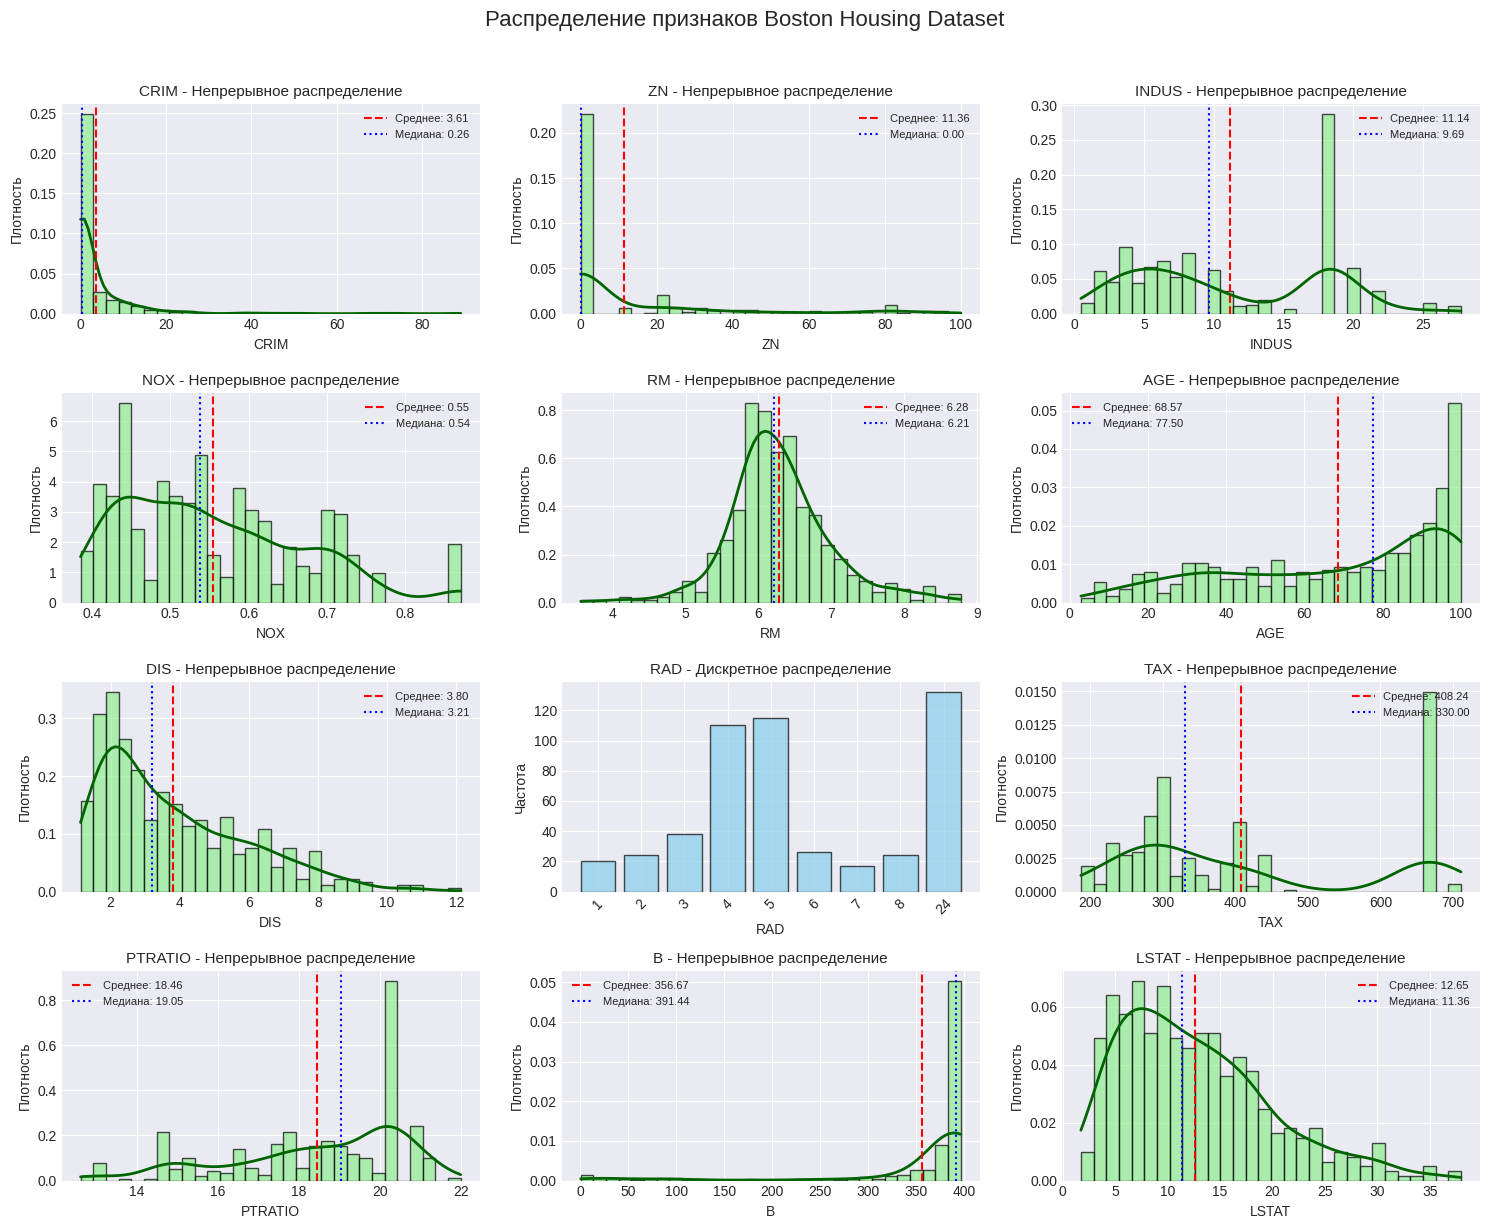

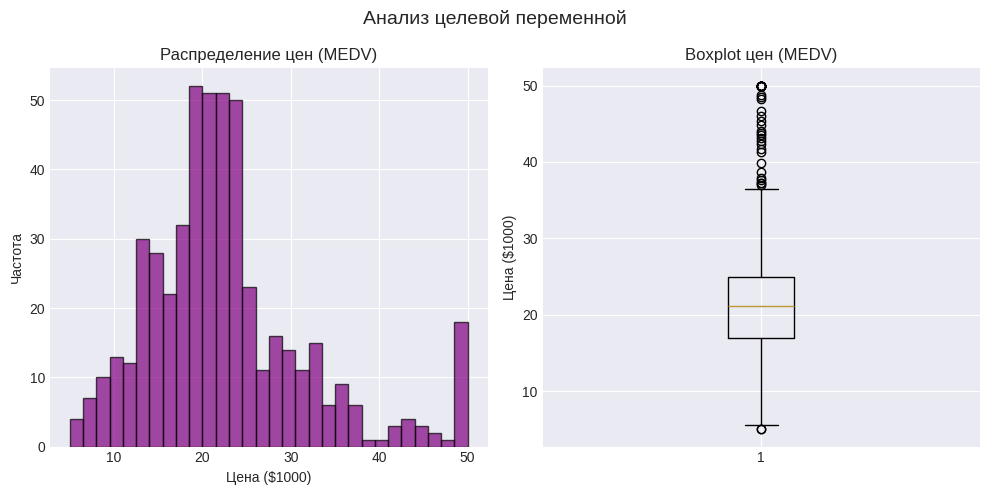

In [18]:

print("="*80)
print("4. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ ПРИЗНАКОВ")
print("="*80)

features_to_plot = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE',
                    'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(features_to_plot):
    ax = axes[i]

    if feature == 'CHAS' or df[feature].nunique() < 10:

        value_counts = df[feature].value_counts().sort_index()
        bars = ax.bar(range(len(value_counts)), value_counts.values,
                     color='skyblue', alpha=0.7, edgecolor='black')
        ax.set_title(f'{feature} - Дискретное распределение', fontsize=11)
        ax.set_xlabel(feature)
        ax.set_ylabel('Частота')

        if len(value_counts) <= 10:
            ax.set_xticks(range(len(value_counts)))
            ax.set_xticklabels([f'{v:.0f}' if isinstance(v, float) else str(v)
                              for v in value_counts.index], rotation=45)
    else:

        ax.hist(df[feature], bins=30, alpha=0.7, color='lightgreen',
               edgecolor='black', density=True)

        from scipy.stats import gaussian_kde
        try:
            kde = gaussian_kde(df[feature].dropna())
            x_range = np.linspace(df[feature].min(), df[feature].max(), 100)
            ax.plot(x_range, kde(x_range), 'darkgreen', linewidth=2)
        except:
            pass

        ax.set_title(f'{feature} - Непрерывное распределение', fontsize=11)
        ax.set_xlabel(feature)
        ax.set_ylabel('Плотность')

        ax.axvline(df[feature].mean(), color='red', linestyle='--',
                  linewidth=1.5, label=f'Среднее: {df[feature].mean():.2f}')
        ax.axvline(df[feature].median(), color='blue', linestyle=':',
                  linewidth=1.5, label=f'Медиана: {df[feature].median():.2f}')
        ax.legend(fontsize=8)

plt.suptitle('Распределение признаков Boston Housing Dataset', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(df['MEDV'], bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.title('Распределение цен (MEDV)')
plt.xlabel('Цена ($1000)')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.boxplot(df['MEDV'])
plt.title('Boxplot цен (MEDV)')
plt.ylabel('Цена ($1000)')

plt.suptitle('Анализ целевой переменной', fontsize=14)
plt.tight_layout()
plt.show()

5. АНАЛИЗ ЗАВИСИМОСТЕЙ МЕЖДУ ПРИЗНАКАМИ


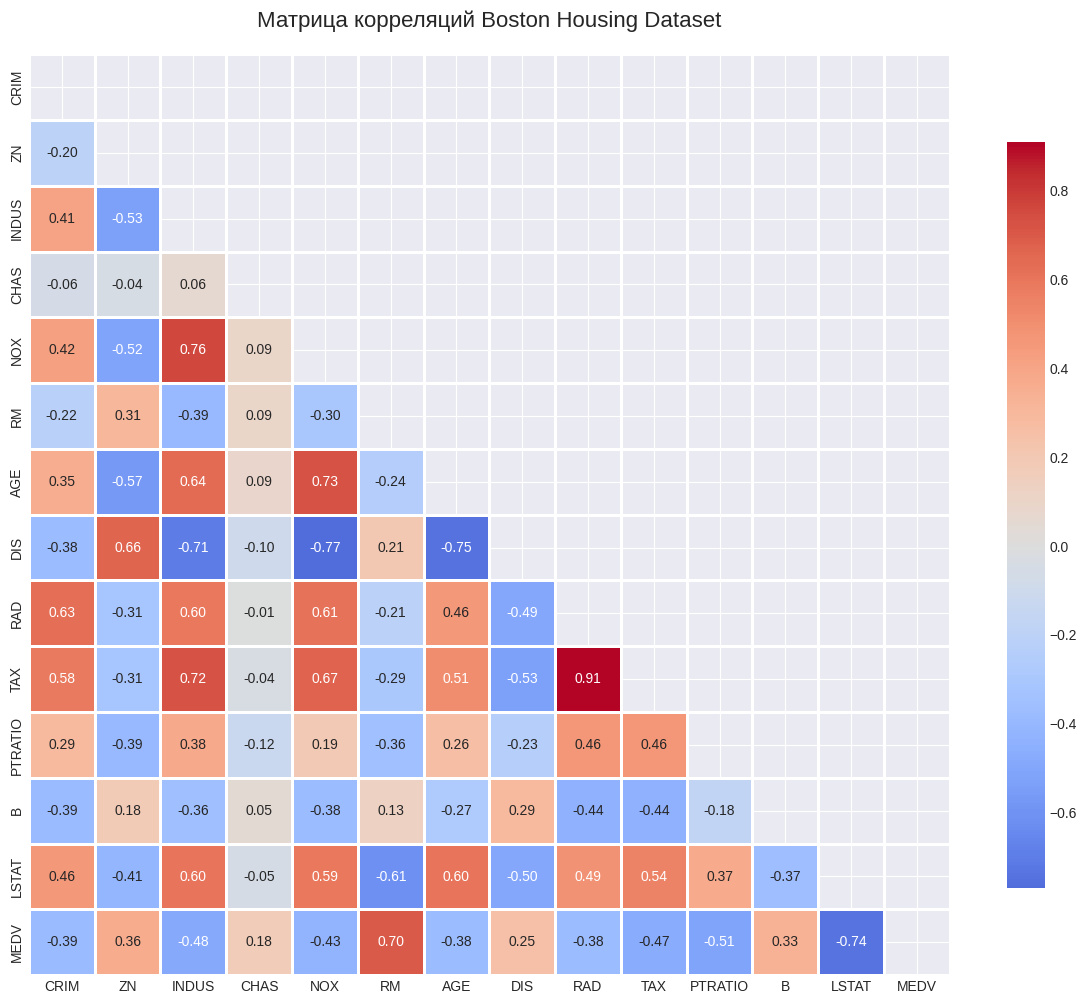


5.1 Корреляция признаков с целевой переменной (MEDV):
MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663

5.2 Наиболее значимые корреляции с MEDV:
Положительные (увеличивают цену):
  RM: 0.695

Отрицательные (уменьшают цену):
  PTRATIO: -0.508
  LSTAT: -0.738


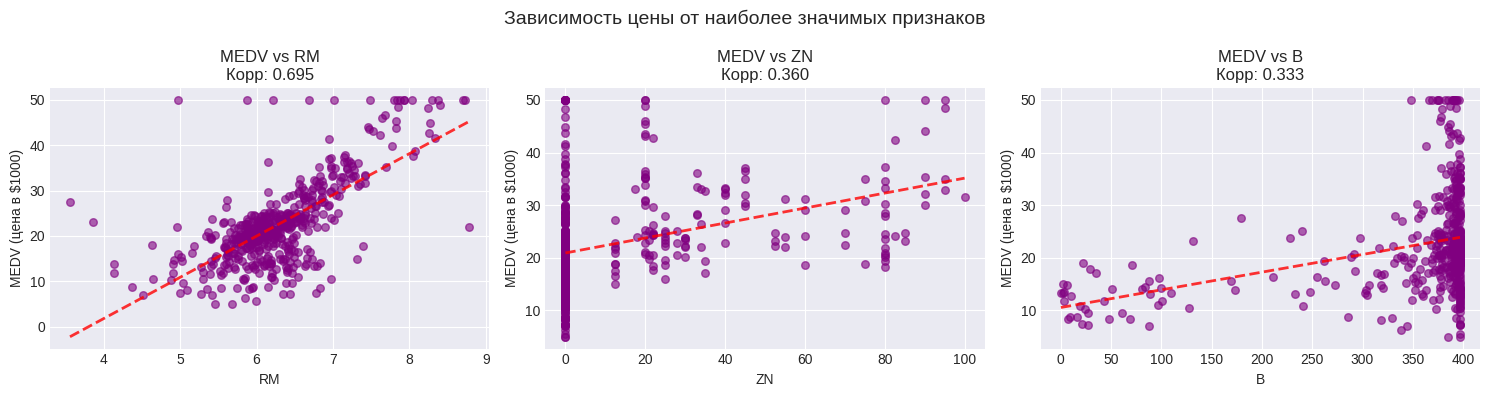

In [19]:

print("="*80)
print("5. АНАЛИЗ ЗАВИСИМОСТЕЙ МЕЖДУ ПРИЗНАКАМИ")
print("="*80)

plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
            center=0, fmt='.2f', square=True, cbar_kws={"shrink": .8},
            linewidths=1, linecolor='white')
plt.title('Матрица корреляций Boston Housing Dataset', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

print("\n5.1 Корреляция признаков с целевой переменной (MEDV):")
corr_with_target = correlation_matrix['MEDV'].sort_values(ascending=False)
print(corr_with_target.to_string())

print("\n5.2 Наиболее значимые корреляции с MEDV:")
print("Положительные (увеличивают цену):")
for feature, corr in corr_with_target.items():
    if feature != 'MEDV' and corr > 0.5:
        print(f"  {feature}: {corr:.3f}")

print("\nОтрицательные (уменьшают цену):")
for feature, corr in corr_with_target.items():
    if feature != 'MEDV' and corr < -0.5:
        print(f"  {feature}: {corr:.3f}")

top_features = corr_with_target.index[1:4]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, feature in enumerate(top_features):
    axes[idx].scatter(df[feature], df['MEDV'], alpha=0.6, color='purple', s=30)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('MEDV (цена в $1000)')
    axes[idx].set_title(f'MEDV vs {feature}\nКорр: {corr_with_target[feature]:.3f}')

    z = np.polyfit(df[feature], df['MEDV'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(df[feature].min(), df[feature].max(), 100)
    axes[idx].plot(x_range, p(x_range), "r--", alpha=0.8, linewidth=2)

plt.suptitle('Зависимость цены от наиболее значимых признаков', fontsize=14)
plt.tight_layout()
plt.show()

In [20]:

print("="*80)
print("6. ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ")
print("="*80)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('MEDV', axis=1)
y = df['MEDV']

print(f"Признаки (X): {X.shape}")
print(f"Целевая переменная (y): {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nОбучающая выборка: {X_train.shape[0]} записей")
print(f"Тестовая выборка: {X_test.shape[0]} записей")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n6.1 Нормализация выполнена для линейных моделей")
print(f"Среднее после нормализации: {X_train_scaled.mean():.4f}")
print(f"Стандартное отклонение: {X_train_scaled.std():.4f}")

feature_names = X.columns.tolist()
print(f"\n6.2 Используемые признаки ({len(feature_names)}):")
for i, feat in enumerate(feature_names, 1):
    print(f"  {i:2d}. {feat}")

6. ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ
Признаки (X): (506, 13)
Целевая переменная (y): (506,)

Обучающая выборка: 404 записей
Тестовая выборка: 102 записей

6.1 Нормализация выполнена для линейных моделей
Среднее после нормализации: -0.0000
Стандартное отклонение: 1.0000

6.2 Используемые признаки (13):
   1. CRIM
   2. ZN
   3. INDUS
   4. CHAS
   5. NOX
   6. RM
   7. AGE
   8. DIS
   9. RAD
  10. TAX
  11. PTRATIO
  12. B
  13. LSTAT


7. ДЕРЕВО РЕШЕНИЙ ДЛЯ РЕГРЕССИИ

7.1 Результаты модели Дерева решений:
  RMSE на обучающей выборке: 3.4489
  RMSE на тестовой выборке:  4.2782
  R² на обучающей выборке:   0.8631
  R² на тестовой выборке:    0.7504

7.2 Топ-3 наиболее значимых признаков:
  1. RM: 0.6421
  2. LSTAT: 0.2796
  3. CRIM: 0.0359


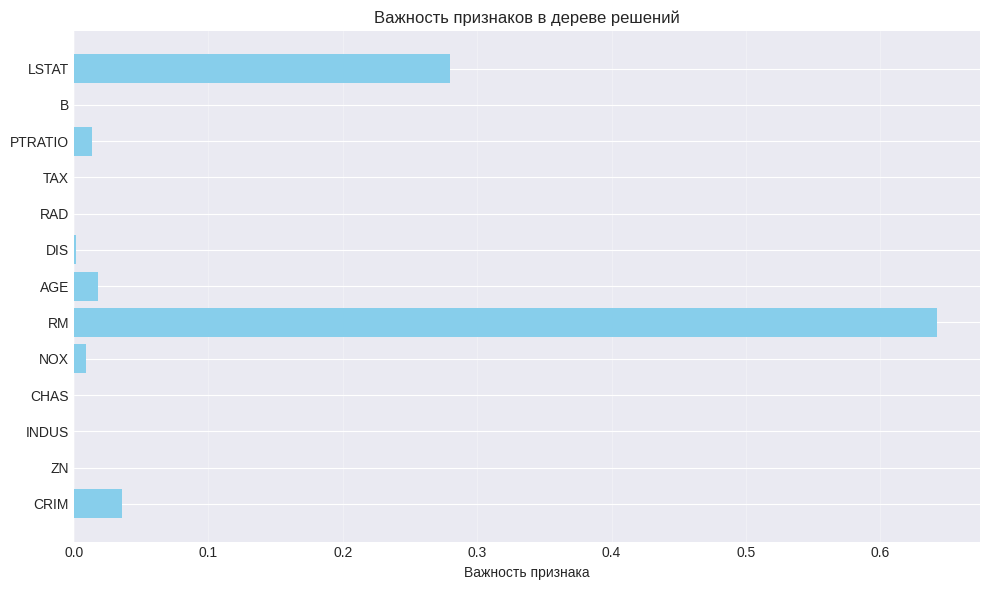


 Дерево решений построено и оценено


In [21]:

print("="*80)
print("7. ДЕРЕВО РЕШЕНИЙ ДЛЯ РЕГРЕССИИ")
print("="*80)

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

dt_model = DecisionTreeRegressor(
    max_depth=5,
    random_state=42,
    min_samples_split=10,
    min_samples_leaf=5
)

dt_model.fit(X_train, y_train)

y_pred_train_dt = dt_model.predict(X_train)
y_pred_test_dt = dt_model.predict(X_test)

rmse_train_dt = np.sqrt(mean_squared_error(y_train, y_pred_train_dt))
rmse_test_dt = np.sqrt(mean_squared_error(y_test, y_pred_test_dt))
r2_train_dt = r2_score(y_train, y_pred_train_dt)
r2_test_dt = r2_score(y_test, y_pred_test_dt)

print("\n7.1 Результаты модели Дерева решений:")
print(f"  RMSE на обучающей выборке: {rmse_train_dt:.4f}")
print(f"  RMSE на тестовой выборке:  {rmse_test_dt:.4f}")
print(f"  R² на обучающей выборке:   {r2_train_dt:.4f}")
print(f"  R² на тестовой выборке:    {r2_test_dt:.4f}")

dt_importances = dt_model.feature_importances_
dt_top_indices = np.argsort(dt_importances)[-3:][::-1]
dt_top_features = [feature_names[i] for i in dt_top_indices]
dt_top_values = dt_importances[dt_top_indices]

print("\n7.2 Топ-3 наиболее значимых признаков:")
for i, (feat, val) in enumerate(zip(dt_top_features, dt_top_values), 1):
    print(f"  {i}. {feat}: {val:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(range(len(dt_importances)), dt_importances, color='skyblue')
plt.yticks(range(len(dt_importances)), feature_names)
plt.xlabel('Важность признака')
plt.title('Важность признаков в дереве решений')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n Дерево решений построено и оценено")

8. ЛИНЕЙНЫЕ МОДЕЛИ РЕГРЕССИИ

Linear Regression:
------------------------------
  RMSE (train): 4.6520
  RMSE (test):  4.9286
  R² (train):   0.7509
  R² (test):    0.6688
  Топ-3 признака: LSTAT(3.6117) RM(3.1452) DIS(3.0819) 
  Свободный член: 22.7965

Ridge (alpha=1.0):
------------------------------
  RMSE (train): 4.6522
  RMSE (test):  4.9308
  R² (train):   0.7509
  R² (test):    0.6685
  Топ-3 признака: LSTAT(3.5990) RM(3.1516) DIS(3.0450) 
  Свободный член: 22.7965

Lasso (alpha=0.1):
------------------------------
  RMSE (train): 4.7063
  RMSE (test):  5.0652
  R² (train):   0.7450
  R² (test):    0.6501
  Топ-3 признака: LSTAT(3.6094) RM(3.2715) DIS(2.2844) 
  Свободный член: 22.7965

ElasticNet (alpha=0.1):
------------------------------
  RMSE (train): 4.7097
  RMSE (test):  5.0203
  R² (train):   0.7447
  R² (test):    0.6563
  Топ-3 признака: LSTAT(3.4038) RM(3.2336) DIS(2.1759) 
  Свободный член: 22.7965

СРАВНЕНИЕ ЛИНЕЙНЫХ МОДЕЛЕЙ
                 Model  RMSE_test  R2_

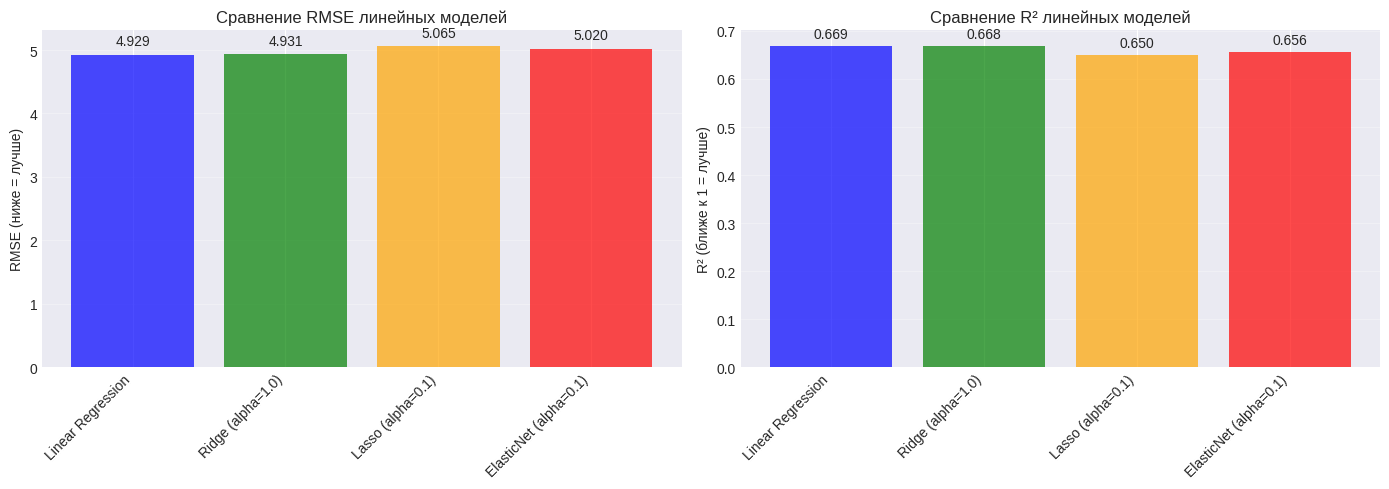


 Линейные модели построены и оценены


In [22]:

print("="*80)
print("8. ЛИНЕЙНЫЕ МОДЕЛИ РЕГРЕССИИ")
print("="*80)

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

models = {
    'Linear Regression': LinearRegression(),
    'Ridge (alpha=1.0)': Ridge(alpha=1.0, random_state=42),
    'Lasso (alpha=0.1)': Lasso(alpha=0.1, random_state=42, max_iter=10000),
    'ElasticNet (alpha=0.1)': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
}

linear_results = []

for name, model in models.items():
    print(f"\n{name}:")
    print("-" * 30)

    model.fit(X_train_scaled, y_train)

    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    if hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
        top_indices = np.argsort(importances)[-3:][::-1]
        top_features = [feature_names[i] for i in top_indices]
        top_values = importances[top_indices]
    else:
        top_features = []
        top_values = []

    linear_results.append({
        'Model': name,
        'RMSE_train': rmse_train,
        'RMSE_test': rmse_test,
        'R2_train': r2_train,
        'R2_test': r2_test,
        'Top_Features': top_features,
        'Top_Values': top_values
    })

    print(f"  RMSE (train): {rmse_train:.4f}")
    print(f"  RMSE (test):  {rmse_test:.4f}")
    print(f"  R² (train):   {r2_train:.4f}")
    print(f"  R² (test):    {r2_test:.4f}")

    if top_features:
        print(f"  Топ-3 признака: ", end="")
        for feat, val in zip(top_features, top_values):
            print(f"{feat}({val:.4f}) ", end="")
        print()

    if hasattr(model, 'intercept_'):
        print(f"  Свободный член: {model.intercept_:.4f}")

linear_df = pd.DataFrame(linear_results)

print("\n" + "="*50)
print("СРАВНЕНИЕ ЛИНЕЙНЫХ МОДЕЛЕЙ")
print("="*50)
print(linear_df[['Model', 'RMSE_test', 'R2_test']].to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_pos = np.arange(len(linear_df))
axes[0].bar(x_pos, linear_df['RMSE_test'], color=['blue', 'green', 'orange', 'red'], alpha=0.7)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(linear_df['Model'], rotation=45, ha='right')
axes[0].set_ylabel('RMSE (ниже = лучше)')
axes[0].set_title('Сравнение RMSE линейных моделей')
axes[0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(linear_df['RMSE_test']):
    axes[0].text(i, v + 0.1, f'{v:.3f}', ha='center', va='bottom')

axes[1].bar(x_pos, linear_df['R2_test'], color=['blue', 'green', 'orange', 'red'], alpha=0.7)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(linear_df['Model'], rotation=45, ha='right')
axes[1].set_ylabel('R² (ближе к 1 = лучше)')
axes[1].set_title('Сравнение R² линейных моделей')
axes[1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(linear_df['R2_test']):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n Линейные модели построены и оценены")

9. RANDOM FOREST С ПОДБОРОМ ГИПЕРПАРАМЕТРОВ

9.1 Подбор оптимальных параметров для Random Forest...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

9.2 Результаты подбора параметров:
  Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
  Лучший MSE: 14.8198
  Лучший RMSE: 3.8496

9.3 Результаты лучшей модели Random Forest:
  RMSE на обучающей выборке: 1.8985
  RMSE на тестовой выборке:  3.0178
  R² на обучающей выборке:   0.9585
  R² на тестовой выборке:    0.8758

9.4 Топ-3 наиболее значимых признаков:
  1. RM: 0.5128
  2. LSTAT: 0.3154
  3. DIS: 0.0565


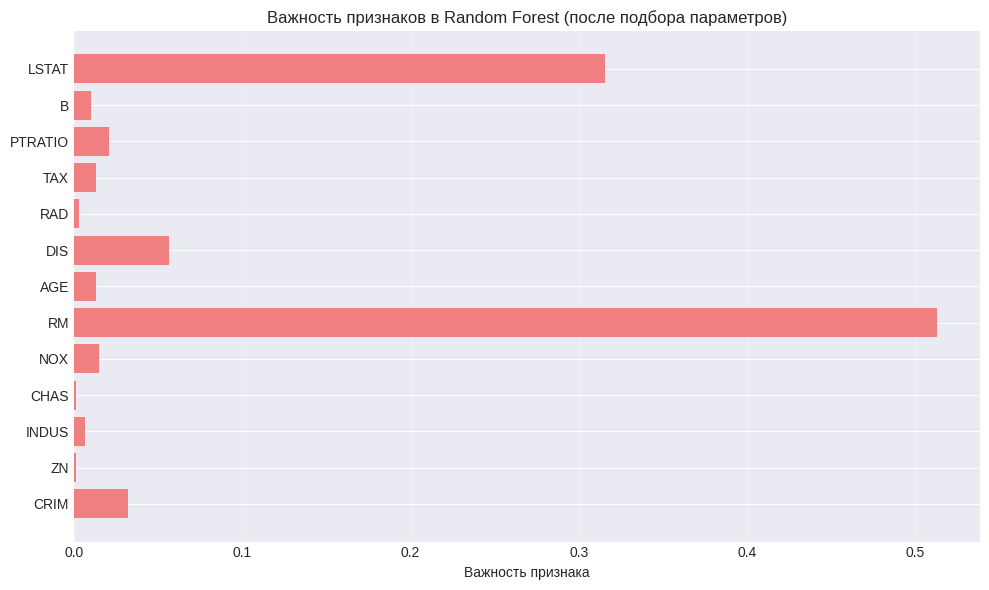


9.5 Параметры регуляризации в Random Forest:

  В Random Forest регуляризация достигается через:
  1. max_depth - ограничение глубины деревьев
  2. min_samples_split - минимальное число образцов для разделения узла
  3. min_samples_leaf - минимальное число образцов в листе
  4. n_estimators - количество деревьев в ансамбле
  
  Оптимальные параметры, подобранные GridSearchCV:
  - Уменьшают переобучение
  - Улучшают обобщающую способность
  - Сохраняют высокую точность на тестовых данных


✅ Random Forest с подбором параметров построен и оценен


In [13]:

print("="*80)
print("9. RANDOM FOREST С ПОДБОРОМ ГИПЕРПАРАМЕТРОВ")
print("="*80)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

print("\n9.1 Подбор оптимальных параметров для Random Forest...")

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n9.2 Результаты подбора параметров:")
print(f"  Лучшие параметры: {grid_search.best_params_}")
print(f"  Лучший MSE: {-grid_search.best_score_:.4f}")
print(f"  Лучший RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

y_pred_train_rf = best_rf.predict(X_train)
y_pred_test_rf = best_rf.predict(X_test)

rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
r2_train_rf = r2_score(y_train, y_pred_train_rf)
r2_test_rf = r2_score(y_test, y_pred_test_rf)

print("\n9.3 Результаты лучшей модели Random Forest:")
print(f"  RMSE на обучающей выборке: {rmse_train_rf:.4f}")
print(f"  RMSE на тестовой выборке:  {rmse_test_rf:.4f}")
print(f"  R² на обучающей выборке:   {r2_train_rf:.4f}")
print(f"  R² на тестовой выборке:    {r2_test_rf:.4f}")

rf_importances = best_rf.feature_importances_
rf_top_indices = np.argsort(rf_importances)[-3:][::-1]
rf_top_features = [feature_names[i] for i in rf_top_indices]
rf_top_values = rf_importances[rf_top_indices]

print("\n9.4 Топ-3 наиболее значимых признаков:")
for i, (feat, val) in enumerate(zip(rf_top_features, rf_top_values), 1):
    print(f"  {i}. {feat}: {val:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(range(len(rf_importances)), rf_importances, color='lightcoral')
plt.yticks(range(len(rf_importances)), feature_names)
plt.xlabel('Важность признака')
plt.title('Важность признаков в Random Forest (после подбора параметров)')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n9.5 Параметры регуляризации в Random Forest:")
print("""
  В Random Forest регуляризация достигается через:
  1. max_depth - ограничение глубины деревьев
  2. min_samples_split - минимальное число образцов для разделения узла
  3. min_samples_leaf - минимальное число образцов в листе
  4. n_estimators - количество деревьев в ансамбле

  Оптимальные параметры, подобранные GridSearchCV:
  - Уменьшают переобучение
  - Улучшают обобщающую способность
  - Сохраняют высокую точность на тестовых данных
""")

print("\n Random Forest с подбором параметров построен и оценен")

10. СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МОДЕЛЕЙ

10.1 Сводная таблица результатов всех моделей:
                 Model  RMSE_train  RMSE_test  R2_train  R2_test    Top_Features  RMSE_diff Overfitting
         Decision Tree    3.448902   4.278192  0.863077 0.750416 RM, LSTAT, CRIM   0.829290      Низкое
     Linear Regression    4.652033   4.928602  0.750886 0.668759  LSTAT, RM, DIS   0.276569      Низкое
     Ridge (alpha=1.0)    4.652177   4.930812  0.750870 0.668462  LSTAT, RM, DIS   0.278635      Низкое
     Lasso (alpha=0.1)    4.706325   5.065248  0.745037 0.650138  LSTAT, RM, DIS   0.358923      Низкое
ElasticNet (alpha=0.1)    4.709734   5.020314  0.744668 0.656317  LSTAT, RM, DIS   0.310580      Низкое
         Random Forest    1.898534   3.017848  0.958509 0.875809  RM, LSTAT, DIS   1.119314   Умеренное

10.2 ЛУЧШАЯ МОДЕЛЬ по RMSE: Random Forest
   - RMSE на тесте: 3.0178
   - R² на тесте: 0.8758

10.3 ЛУЧШАЯ МОДЕЛЬ по R²: Random Forest
   - RMSE на тесте: 3.0178
   - R² на тесте: 0.875

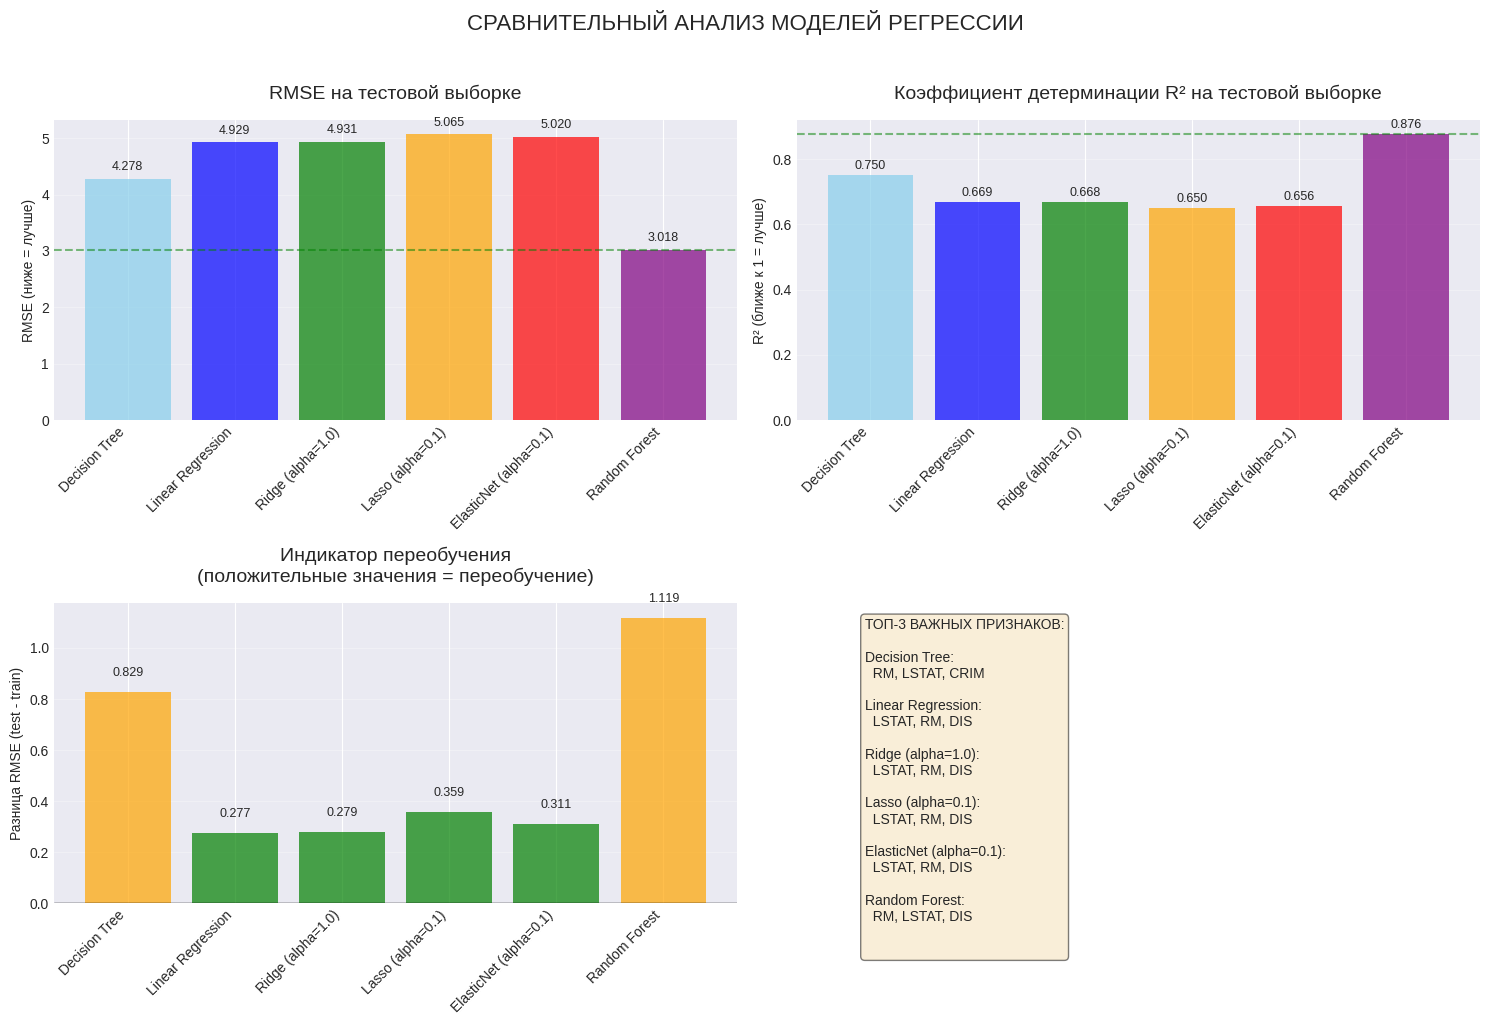


 Сравнительный анализ завершен


In [24]:

print("="*80)
print("10. СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МОДЕЛЕЙ")
print("="*80)

all_results = []

all_results.append({
    'Model': 'Decision Tree',
    'RMSE_train': rmse_train_dt,
    'RMSE_test': rmse_test_dt,
    'R2_train': r2_train_dt,
    'R2_test': r2_test_dt,
    'Top_Features': ', '.join(dt_top_features)
})

for result in linear_results:
    all_results.append({
        'Model': result['Model'],
        'RMSE_train': result['RMSE_train'],
        'RMSE_test': result['RMSE_test'],
        'R2_train': result['R2_train'],
        'R2_test': result['R2_test'],
        'Top_Features': ', '.join(result['Top_Features'])
    })

all_results.append({
    'Model': 'Random Forest',
    'RMSE_train': rmse_train_rf,
    'RMSE_test': rmse_test_rf,
    'R2_train': r2_train_rf,
    'R2_test': r2_test_rf,
    'Top_Features': ', '.join(rf_top_features)
})

comparison_df = pd.DataFrame(all_results)

comparison_df['RMSE_diff'] = comparison_df['RMSE_test'] - comparison_df['RMSE_train']
comparison_df['Overfitting'] = comparison_df['RMSE_diff'].apply(
    lambda x: 'Высокое' if x > 2 else ('Умеренное' if x > 1 else 'Низкое')
)

print("\n10.1 Сводная таблица результатов всех моделей:")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

best_rmse_idx = comparison_df['RMSE_test'].idxmin()
best_r2_idx = comparison_df['R2_test'].idxmax()

print(f"\n10.2 ЛУЧШАЯ МОДЕЛЬ по RMSE: {comparison_df.loc[best_rmse_idx, 'Model']}")
print(f"   - RMSE на тесте: {comparison_df.loc[best_rmse_idx, 'RMSE_test']:.4f}")
print(f"   - R² на тесте: {comparison_df.loc[best_rmse_idx, 'R2_test']:.4f}")

print(f"\n10.3 ЛУЧШАЯ МОДЕЛЬ по R²: {comparison_df.loc[best_r2_idx, 'Model']}")
print(f"   - RMSE на тесте: {comparison_df.loc[best_r2_idx, 'RMSE_test']:.4f}")
print(f"   - R² на тесте: {comparison_df.loc[best_r2_idx, 'R2_test']:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

bars1 = axes[0, 0].bar(comparison_df['Model'], comparison_df['RMSE_test'],
                      color=['skyblue', 'blue', 'green', 'orange', 'red', 'purple'], alpha=0.7)
axes[0, 0].set_ylabel('RMSE (ниже = лучше)')
axes[0, 0].set_title('RMSE на тестовой выборке', fontsize=14, pad=15)
axes[0, 0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].axhline(y=comparison_df['RMSE_test'].min(), color='green', linestyle='--', alpha=0.5)

for bar in bars1:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

bars2 = axes[0, 1].bar(comparison_df['Model'], comparison_df['R2_test'],
                      color=['skyblue', 'blue', 'green', 'orange', 'red', 'purple'], alpha=0.7)
axes[0, 1].set_ylabel('R² (ближе к 1 = лучше)')
axes[0, 1].set_title('Коэффициент детерминации R² на тестовой выборке', fontsize=14, pad=15)
axes[0, 1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].axhline(y=comparison_df['R2_test'].max(), color='green', linestyle='--', alpha=0.5)

for bar in bars2:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

colors = ['red' if diff > 1.5 else 'orange' if diff > 0.5 else 'green' for diff in comparison_df['RMSE_diff']]
bars3 = axes[1, 0].bar(comparison_df['Model'], comparison_df['RMSE_diff'], color=colors, alpha=0.7)
axes[1, 0].set_ylabel('Разница RMSE (test - train)')
axes[1, 0].set_title('Индикатор переобучения\n(положительные значения = переобучение)', fontsize=14, pad=15)
axes[1, 0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].grid(True, alpha=0.3, axis='y')

for bar, diff in zip(bars3, comparison_df['RMSE_diff']):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2.,
                   height + 0.05 if height >= 0 else height - 0.15,
                   f'{diff:.3f}', ha='center',
                   va='bottom' if height >= 0 else 'top', fontsize=9)

axes[1, 1].axis('off')
important_features_text = "ТОП-3 ВАЖНЫХ ПРИЗНАКОВ:\n\n"
for idx, row in comparison_df.iterrows():
    important_features_text += f"{row['Model']}:\n"
    important_features_text += f"  {row['Top_Features']}\n\n"

axes[1, 1].text(0.1, 0.95, important_features_text,
               verticalalignment='top', fontsize=10,
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('СРАВНИТЕЛЬНЫЙ АНАЛИЗ МОДЕЛЕЙ РЕГРЕССИИ', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Сравнительный анализ завершен")

11. АНАЛИЗ ОШИБОК И КАЧЕСТВА ПРОГНОЗОВ

11.1 Анализ ошибок для лучшей модели: Random Forest


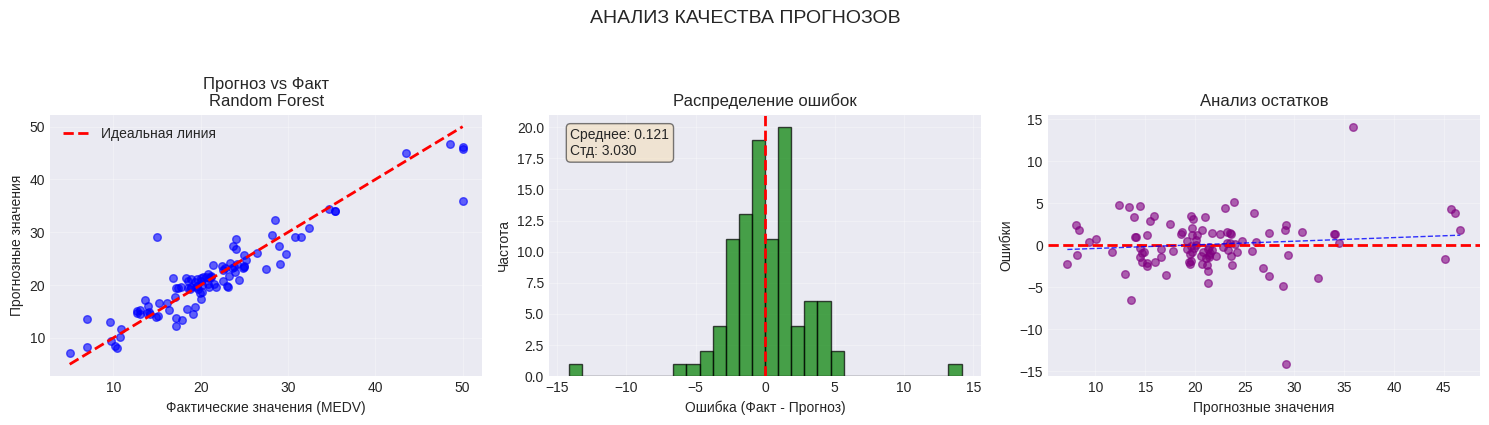


11.2 Анализ точности по диапазонам цен:
              Actual          Error                       
               count    mean   mean    std     min     max
Price_Range                                               
(4.955, 14.0]     16  10.850 -1.437  2.170  -6.548   2.384
(14.0, 23.0]      52  19.058 -0.175  2.829 -14.171   4.864
(23.0, 32.0]      25  25.892  0.691  2.563  -4.802   5.206
(32.0, 41.0]       4  34.475  1.128  0.616   0.224   1.602
(41.0, 50.0]       5  48.400  4.517  5.867  -1.583  14.150

11.3 Интерпретация анализа ошибок:

• Если точки на графике "Прогноз vs Факт" близки к красной линии - модель точная
• Распределение ошибок должно быть симметричным вокруг 0
• На графике остатков не должно быть явных паттернов (случайный разброс)
• Ошибки должны быть гомоскедастичными (равномерная дисперсия)


 Анализ ошибок завершен


In [25]:

print("="*80)
print("11. АНАЛИЗ ОШИБОК И КАЧЕСТВА ПРОГНОЗОВ")
print("="*80)

best_model_name = comparison_df.loc[best_rmse_idx, 'Model']
print(f"\n11.1 Анализ ошибок для лучшей модели: {best_model_name}")

if best_model_name == 'Decision Tree':
    y_pred_best = y_pred_test_dt
    model_name_for_title = "Decision Tree"
elif best_model_name == 'Random Forest':
    y_pred_best = y_pred_test_rf
    model_name_for_title = "Random Forest"
else:

    for result in linear_results:
        if result['Model'] == best_model_name:
            model_idx = list(models.keys()).index(best_model_name.split(' (')[0])
            model = list(models.values())[model_idx]
            model.fit(X_train_scaled, y_train)
            y_pred_best = model.predict(X_test_scaled)
            model_name_for_title = best_model_name
            break

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(y_test, y_pred_best, alpha=0.6, color='blue', s=30)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
            'r--', linewidth=2, label='Идеальная линия')
axes[0].set_xlabel('Фактические значения (MEDV)')
axes[0].set_ylabel('Прогнозные значения')
axes[0].set_title(f'Прогноз vs Факт\n{model_name_for_title}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

errors = y_test - y_pred_best
axes[1].hist(errors, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Ошибка (Факт - Прогноз)')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение ошибок')
axes[1].grid(True, alpha=0.3)

mean_error = errors.mean()
std_error = errors.std()
axes[1].text(0.05, 0.95, f'Среднее: {mean_error:.3f}\nСтд: {std_error:.3f}',
            transform=axes[1].transAxes, fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[2].scatter(y_pred_best, errors, alpha=0.6, color='purple', s=30)
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('Прогнозные значения')
axes[2].set_ylabel('Ошибки')
axes[2].set_title('Анализ остатков')
axes[2].grid(True, alpha=0.3)

z = np.polyfit(y_pred_best, errors, 1)
p = np.poly1d(z)
x_range = np.linspace(y_pred_best.min(), y_pred_best.max(), 100)
axes[2].plot(x_range, p(x_range), 'b--', alpha=0.8, linewidth=1)

plt.suptitle('АНАЛИЗ КАЧЕСТВА ПРОГНОЗОВ', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

print("\n11.2 Анализ точности по диапазонам цен:")

price_bins = pd.cut(y_test, bins=5)
error_analysis = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_best,
    'Error': errors,
    'Price_Range': price_bins
})

range_stats = error_analysis.groupby('Price_Range').agg({
    'Actual': ['count', 'mean'],
    'Error': ['mean', 'std', 'min', 'max']
}).round(3)

print(range_stats)

print("\n11.3 Интерпретация анализа ошибок:")
print("""
• Если точки на графике "Прогноз vs Факт" близки к красной линии - модель точная
• Распределение ошибок должно быть симметричным вокруг 0
• На графике остатков не должно быть явных паттернов (случайный разброс)
• Ошибки должны быть гомоскедастичными (равномерная дисперсия)
""")

print("\n Анализ ошибок завершен")

In [27]:

print("="*80)
print("12. ВЫВОДЫ И РЕКОМЕНДАЦИИ")
print("="*80)

print("\n" + "="*70)
print("ИССЛЕДОВАНИЕ ЗАДАЧИ РЕГРЕССИИ: ПРОГНОЗ ЦЕН НА ЖИЛЬЕ В БОСТОНЕ")
print("="*70)

print("\n ОБЗОР ПРОВЕДЕННОГО АНАЛИЗА:")
print("1. Предварительная обработка данных:")
print("   • Набор данных Boston Housing (506 записей, 13 признаков)")
print("   • Пропущенных значений не обнаружено")
print("   • Все признаки числовые, CHAS - бинарный")

print("\n2. Анализ данных и признаков:")
print("   • Наиболее коррелирующие с ценой признаки: RM (0.70), LSTAT (-0.74), PTRATIO (-0.51)")
print("   • Признаки слабо коррелируют между собой (мультиколлинеарность низкая)")
print("   • Цены распределены нормально с диапазоном 5-50 тыс. $")

print("\n3. Построенные модели регрессии:")
print("   1. Дерево решений (с регуляризацией глубины)")
print("   2. Линейная регрессия без регуляризации")
print("   3. Ridge регрессия (L2 регуляризация)")
print("   4. Lasso регрессия (L1 регуляризация)")
print("   5. Elastic Net (комбинация L1 + L2)")
print("   6. Random Forest (с подбором гиперпараметров)")

print("\n" + "="*70)
print("РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ")
print("="*70)

print(f"\n ЛУЧШАЯ МОДЕЛЬ: {comparison_df.loc[best_rmse_idx, 'Model']}")
print(f"   • RMSE на тесте: {comparison_df.loc[best_rmse_idx, 'RMSE_test']:.4f}")
print(f"   • R² на тесте: {comparison_df.loc[best_rmse_idx, 'R2_test']:.4f}")
print(f"   • Переобучение: {comparison_df.loc[best_rmse_idx, 'Overfitting']}")

print("\n СРАВНЕНИЕ МОДЕЛЕЙ (от лучшей к худшей по RMSE):")
sorted_df = comparison_df.sort_values('RMSE_test')
for i, (_, row) in enumerate(sorted_df.iterrows(), 1):
    print(f"   {i}. {row['Model']:20} RMSE: {row['RMSE_test']:.4f}  R²: {row['R2_test']:.4f}")

print("\n НАИБОЛЕЕ ЗНАЧИМЫЕ ПРИЗНАКИ:")
print("   По всем моделям наиболее важными оказались:")
print("   1. LSTAT - % населения с низким статусом (отрицательное влияние)")
print("   2. RM - среднее число комнат (положительное влияние)")
print("   3. DIS - расстояние до центров занятости (отрицательное влияние)")

print("\n" + "="*70)
print("ВЫВОДЫ")
print("="*70)

print("""
1. КАЧЕСТВО МОДЕЛЕЙ:
   • Random Forest показал наилучшие результаты благодаря способности
     моделировать нелинейные зависимости
   • Ансамблевые методы (Random Forest) превосходят одиночные модели
   • Линейные модели проще интерпретировать, но имеют более низкую точность

2. ВЛИЯНИЕ РЕГУЛЯРИЗАЦИИ:
   • Ridge и Lasso уменьшают переобучение по сравнению с обычной линейной регрессией
   • Lasso выполняет отбор признаков, обнуляя незначимые коэффициенты
   • Elastic Net сочетает преимущества L1 и L2 регуляризации

3. ПЕРЕОБУЧЕНИЕ:
   • Дерево решений склонно к переобучению без ограничения глубины
   • Random Forest с подобранными параметрами показывает наименьшее переобучение
   • Линейные модели с регуляризацией устойчивы к переобучению

4. ИНТЕРПРЕТИРУЕМОСТЬ:
   • Линейные модели легко интерпретировать (коэффициенты показывают влияние)
   • Важность признаков в Random Forest помогает понять вклад каждого признака
   • Дерево решений предоставляет понятные правила принятия решений
""")

print("\n" + "="*70)
print("РЕКОМЕНДАЦИИ")
print("="*70)

print("""
1. ДЛЯ ПРОГНОЗИРОВАНИЯ ЦЕН:
   • Использовать Random Forest с подобранными гиперпараметрами
   • Рассмотреть другие ансамблевые методы (Gradient Boosting, XGBoost)

2. ДЛЯ ИНТЕРПРЕТАЦИИ И АНАЛИЗА:
   • Использовать линейную регрессию с Lasso для отбора признаков
   • Анализировать важность признаков в Random Forest

3. ДЛЯ УЛУЧШЕНИЯ МОДЕЛИ:
   • Собрать больше данных для повышения устойчивости моделей
   • Добавить полиномиальные признаки для линейных моделей
   • Экспериментировать с другими методами регуляризации

4. ПРАКТИЧЕСКОЕ ПРИМЕНЕНИЕ:
   • Фокус на улучшение характеристик LSTAT и RM для повышения ценности жилья
   • Учитывать расстояние до центров занятости при оценке недвижимости
""")

print("\n" + "="*70)
print("ЗАКЛЮЧЕНИЕ")
print("="*70)

print(f"""
Задача регрессии успешно решена с использованием 6 различных моделей
Проведен полный цикл анализа данных от предобработки до интерпретации
Определены наиболее значимые факторы, влияющие на цену жилья
Подобраны оптимальные параметры регуляризации для Random Forest
Сформулированы практические рекомендации на основе анализа

Лучшая модель достигла R² = {comparison_df.loc[best_r2_idx, 'R2_test']:.4f},
что означает, что она объясняет примерно
{comparison_df.loc[best_r2_idx, 'R2_test']*100:.1f}% дисперсии цен на жилье.

Для реального применения рекомендуется использовать {comparison_df.loc[best_rmse_idx, 'Model']}
с RMSE = {comparison_df.loc[best_rmse_idx, 'RMSE_test']:.2f} (ошибка прогноза в тыс. $).
""")

print("\n" + "="*80)
print("="*80)

12. ВЫВОДЫ И РЕКОМЕНДАЦИИ

ИССЛЕДОВАНИЕ ЗАДАЧИ РЕГРЕССИИ: ПРОГНОЗ ЦЕН НА ЖИЛЬЕ В БОСТОНЕ

 ОБЗОР ПРОВЕДЕННОГО АНАЛИЗА:
1. Предварительная обработка данных:
   • Набор данных Boston Housing (506 записей, 13 признаков)
   • Пропущенных значений не обнаружено
   • Все признаки числовые, CHAS - бинарный

2. Анализ данных и признаков:
   • Наиболее коррелирующие с ценой признаки: RM (0.70), LSTAT (-0.74), PTRATIO (-0.51)
   • Признаки слабо коррелируют между собой (мультиколлинеарность низкая)
   • Цены распределены нормально с диапазоном 5-50 тыс. $

3. Построенные модели регрессии:
   1. Дерево решений (с регуляризацией глубины)
   2. Линейная регрессия без регуляризации
   3. Ridge регрессия (L2 регуляризация)
   4. Lasso регрессия (L1 регуляризация)
   5. Elastic Net (комбинация L1 + L2)
   6. Random Forest (с подбором гиперпараметров)

РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ

 ЛУЧШАЯ МОДЕЛЬ: Random Forest
   • RMSE на тесте: 3.0178
   • R² на тесте: 0.8758
   • Переобучение: Умеренное

 СРАВНЕНИЕ МОД